![Credit card being held in hand](credit_card.jpg)

Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. 
### The Data

The data is a small subset of the Credit Card Approval dataset from the UCI Machine Learning Repository showing the credit card applications a bank receives. The last column in the dataset is the target value.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix

### Understanding the data

In [2]:
# Load the dataset
df = pd.read_csv("cc_approvals.data", header=None, na_values= "?") 
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,g,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,g,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,g,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,g,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,s,0,+


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       678 non-null    object 
 1   1       678 non-null    float64
 2   2       690 non-null    float64
 3   3       684 non-null    object 
 4   4       684 non-null    object 
 5   5       681 non-null    object 
 6   6       681 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    int64  
 13  13      690 non-null    object 
dtypes: float64(3), int64(2), object(9)
memory usage: 75.6+ KB


### Exploratory Data Analysis

We observed that column 12 exhibits extreme values. Specifically, the maximum value significantly deviates from the 3rd quartile (Q3). These extreme data points can be classified as outliers. They represent approximately **16.38 percent** of the total dataframe. Since we have encrypted variables, it will be not recommended to change these values, unless we got some idea of what they actually are.

In [4]:
df.describe()

,1,2,7,10,12
count,678.000000,690.000000,690.000000,690.00000,690.000000
mean,31.568171,4.758725,2.223406,2.40000,1017.385507
std,11.957862,4.978163,3.346513,4.86294,5210.102598
min,13.750000,0.000000,0.000000,0.00000,0.000000
25%,22.602500,1.000000,0.165000,0.00000,0.000000
50%,28.460000,2.750000,1.000000,0.00000,5.000000
75%,38.230000,7.207500,2.625000,3.00000,395.500000
max,80.250000,28.000000,28.500000,67.00000,100000.000000


In [5]:
# Looking at the percent of atypical data 
print("Percentage of outliers in column 12 to the total dataframe: {} %".format(round(len(df[df[12] > 395.5 + (1.5 * (395.5 - 0))])/len(df) * 100, 2)))

Percentage of outliers in column 12 to the total dataframe: 16.38 %


Since null values in each column account for less than 5% of the total dataframe, we are going to drop them, to improve even more our model.

In [6]:
print("Column NA values" )
print(df.isna().sum().sort_values())

Column NA values
2      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
3      6
4      6
5      9
6      9
0     12
1     12
dtype: int64


In [7]:
df = df.dropna()
print(df.isna().sum().sort_values())

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
dtype: int64


We can see now that the dataframe went from 690 rows to 659 rows. We dropped less than 5% values total.

In [8]:
df.shape

(659, 14)

Let's look at the corresponding values for each categorical column.

In [9]:
# Inspecting all values of categorical variables
object_cols = df.select_dtypes(exclude="number").columns

for num in object_cols:
    print("Column {}: {}".format(num, df[num].unique()))

Column 0: ['b' 'a']
Column 3: ['u' 'y' 'l']
Column 4: ['g' 'p' 'gg']
Column 5: ['w' 'q' 'm' 'r' 'cc' 'k' 'c' 'd' 'x' 'i' 'e' 'aa' 'ff' 'j']
Column 6: ['v' 'h' 'bb' 'ff' 'j' 'z' 'o' 'dd' 'n']
Column 8: ['t' 'f']
Column 9: ['t' 'f']
Column 11: ['g' 's' 'p']
Column 13: ['+' '-']


 Let’s formalize the process of converting the target variable to binary based on the assumption that **+** represents approval (1) and **-** represents non-approval (0). 

By using the code below, we convert the **+** values to 1 and the **-** values to 0.

In [10]:
# Casting target variable to numeric
df[13] = (df[13] == "+").astype(int)

Target values look balanced.

In [11]:
df[13].value_counts()

0    361
1    298
Name: 13, dtype: int64

#### Graphical exploration

Although the column meanings remain encrypted for security reasons, we can still derive insights by visualizing the relationships between each variable and the target variable. Graphical exploration is a valuable technique even when specific feature interpretations are unavailable.

In [12]:
df.select_dtypes(include="number").columns

Int64Index([1, 2, 7, 10, 12, 13], dtype='int64')

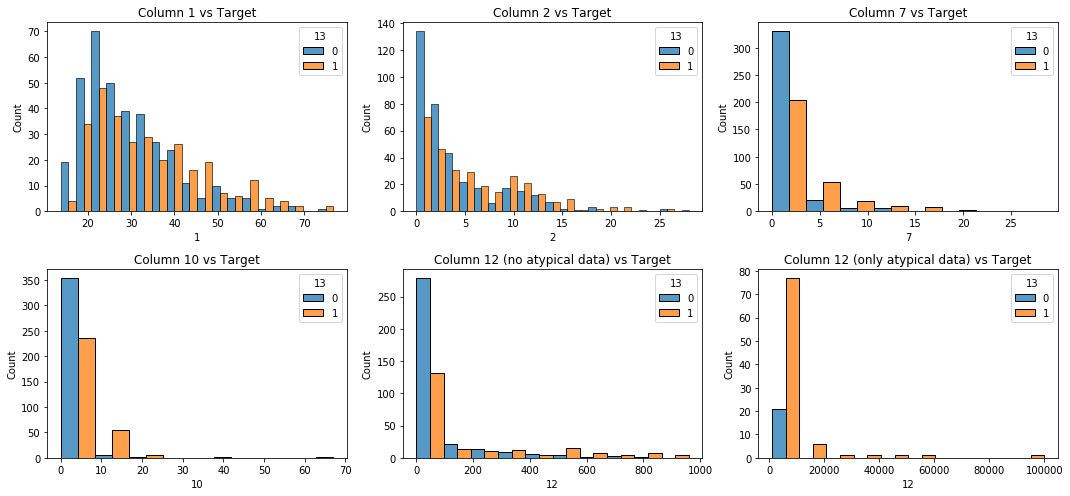

In [13]:
# Set up the subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 7))

# Create histograms
sns.histplot(data=df, x=1, hue=13, ax=axs[0, 0], multiple="dodge")
sns.histplot(data=df, x=2, hue=13, ax=axs[0, 1], multiple="dodge")
sns.histplot(data=df, x=7, hue=13, ax=axs[0, 2], bins=8, multiple="dodge")
sns.histplot(data=df, x=10, hue=13, ax=axs[1, 0], bins=8, multiple="dodge")
sns.histplot(data=df[df[12] <  395.5 + (1.5 * (395.5 - 0))], x=12, hue=13, ax=axs[1, 1], multiple="dodge", bins=10)
sns.histplot(data=df[df[12] >=  395.5 + (1.5 * (395.5 - 0))], x=12, hue=13, ax=axs[1, 2], multiple="dodge", bins=10)
# Set titles for each subplot
axs[0, 0].set_title("Column 1 vs Target")
axs[0, 1].set_title("Column 2 vs Target")
axs[0, 2].set_title("Column 7 vs Target")
axs[1, 0].set_title("Column 10 vs Target")
axs[1, 1].set_title("Column 12 (no atypical data) vs Target")
axs[1, 2].set_title("Column 12 (only atypical data) vs Target")

plt.tight_layout()
plt.show()

Observations:
* Column 12 low values are mostly 0s, or "not approved".
* Column 12 high values are mostly 1s, or "approved".
* Low values of every variable are predominant by 0s.

In [14]:
df.select_dtypes(exclude="number").columns

Int64Index([0, 3, 4, 5, 6, 8, 9, 11], dtype='int64')

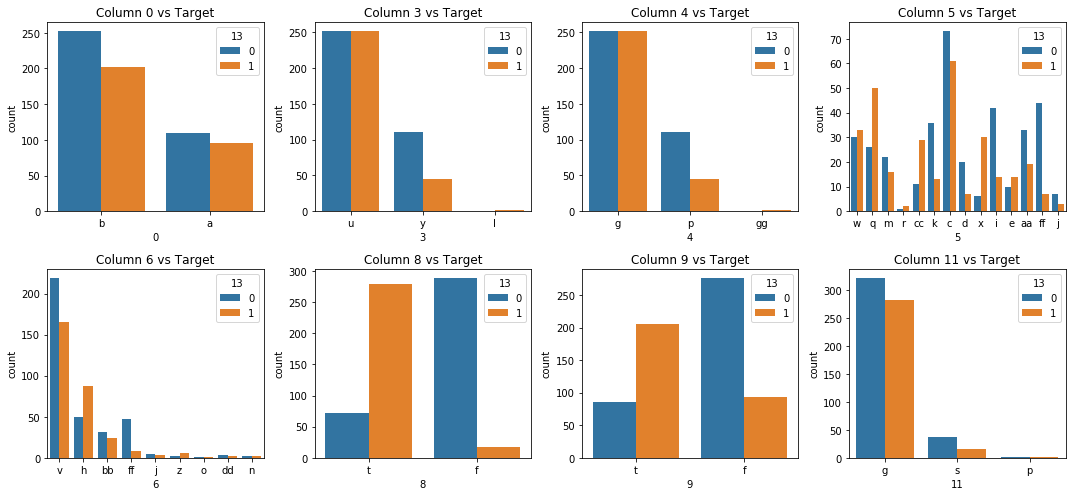

In [15]:
# Set up the subplots
fig, axs = plt.subplots(2, 4, figsize=(15, 7))

# Create bar graphs
sns.countplot(data=df, x=0, hue=13, ax=axs[0,0])
sns.countplot(data=df, x=3, hue=13, ax=axs[0,1])
sns.countplot(data=df, x=4, hue=13, ax=axs[0,2])
sns.countplot(data=df, x=5, hue=13, ax=axs[0,3])

sns.countplot(data=df, x=6, hue=13, ax=axs[1,0])
sns.countplot(data=df, x=8, hue=13, ax=axs[1,1])
sns.countplot(data=df, x=9, hue=13, ax=axs[1,2])
sns.countplot(data=df, x=11, hue=13, ax=axs[1,3])

# Set titles for each subplot
axs[0, 0].set_title("Column 0 vs Target")
axs[0, 1].set_title("Column 3 vs Target")
axs[0, 2].set_title("Column 4 vs Target")
axs[0, 3].set_title("Column 5 vs Target")
axs[1, 0].set_title("Column 6 vs Target")
axs[1, 1].set_title("Column 8 vs Target")
axs[1, 2].set_title("Column 9 vs Target")
axs[1, 3].set_title("Column 11 vs Target")

plt.tight_layout()
plt.show()

Observations:
* Column 8 t values are mostly 1s, and f values mostly 0s.
* Same situation is seen in column 9.

### Preparing the data for modeling

Now we will proceed to apply label encoder to the features, and prepare our data to fit the best model. Will also standardize our data for them to be on a similar scale.

In [17]:
le = LabelEncoder()

In [18]:
# Applying label encoder to every categorical feature
for col in df.select_dtypes(exclude="number").columns:
    df[col] = le.fit_transform(df[col])

In [19]:
# Splitting our data into features and target
df_X = df.drop(13, axis=1).values # Features
df_y = df[13].values # Target

# Splitting into train sets and test sets
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size = 0.3, random_state = 42)

In [20]:
scaler = StandardScaler()

# Scaling our features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Choosing the right model

Now we are going to assess different models and select the best choice for use. In order to do this, we need loop through each model and check their respective accuracy scores.

By looking at the plots we can see that the one with the best  cross validation accuracy score is the logistic regression, with around 86% median accuracy score. 

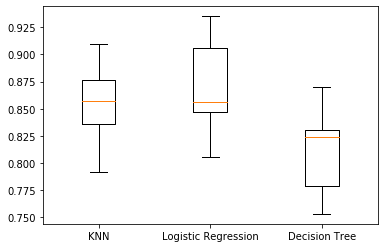

In [21]:
# Defining our models in a dictionary
models = {
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier()
}

result = []
labels = list(models.keys())

# Cross validation on every model defined to check for the best one
for model in models.values():
    kf = KFold(n_splits=6, shuffle=True, random_state=23)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    result.append(cv_results)

# Plotting the results
plt.boxplot(result, labels=labels)
plt.show()

Below we can observe the accuracy test score for each model. KNN and Logistic Regression are very similar, but we will use **KNN** for this project, since it has slightly better score. 

In [22]:
# Best test score for each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    model_score = model.score(X_test_scaled, y_test)
    print("{} Accuracy Test Score: {}".format(name, round(model_score,3)))

KNN Accuracy Test Score: 0.864
Logistic Regression Accuracy Test Score: 0.848
Decision Tree Accuracy Test Score: 0.793


### Making predictions

We got 86% accuracy for the model. The confusion matrix below shows similar proportion of False Positives and False Negatives.

Accuracy of the classification model: 0.8636363636363636


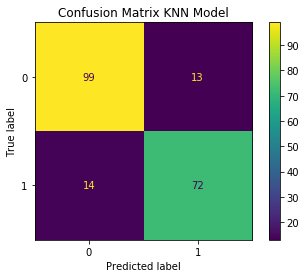

In [23]:
# Making predictions with our best model
y_pred = models["KNN"].predict(X_test_scaled)

print("Accuracy of the classification model: {}".format(models["KNN"].score(X_test_scaled, y_test)))

# Confusion Matrix plot
plot_confusion_matrix(models["KNN"], X_test_scaled, y_test)
plt.title("Confusion Matrix KNN Model")
plt.show()

We can observe in the classification report the total accuracy, as mentioned before, and the other metrics of interest. 

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       112
           1       0.85      0.84      0.84        86

    accuracy                           0.86       198
   macro avg       0.86      0.86      0.86       198
weighted avg       0.86      0.86      0.86       198



### Improving the model hyperparameter

Now, lastly, we are going to find the optimal number of neighbors for the KNN to see the best accuracy according to it. In order to do this we are going to use GridSearchCV module from sklearn.

In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
parameters = {
    "n_neighbors": np.arange(1,50)
}

# GridSearch to tune the number of neighbors
knn_cv = GridSearchCV(models["KNN"], parameters, cv= kf)

knn_cv.fit(X_train_scaled, y_train) 

print("Tuned KNN Parameter: {}".format(knn_cv.best_params_))
print("Tuned KNN Best Accuracy Score: {}".format(knn_cv.best_score_))

Tuned KNN Parameter: {'n_neighbors': 11}
Tuned KNN Best Accuracy Score: 0.8697522206638617


Tuning the number of neighbors helped us improve the overall accuracy of the model from **86%** to **87%** with **11 neighbors**.

### Conclusions

* Among the models evaluated on this dataset, the **K-Nearest Neighbors (KNN)** algorithm achieved the highest accuracy, with a performance of **86%**. In comparison, the Logistic Regression model achieved an accuracy of **85%**, while the Decision Trees model lagged behind at **82%**.
* After fine-tuning the hyperparameter of the K-Nearest Neighbors (KNN) algorithm, we observed an improvement in accuracy by **1%**.
